In [1]:
#import other libraries we will be utilizing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from kagglehub import KaggleDatasetAdapter
import os
import sqlite3
import xml.etree.ElementTree as ET
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

In [2]:
#connect to our database
db_path = "/root/.cache/kagglehub/datasets/hugomathien/soccer/versions/10/database.sqlite"
conn = sqlite3.connect(db_path)

#display sample data
matches = pd.read_sql("SELECT * FROM Match", conn)
display(matches.head())
print(matches.columns)

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


Index(['id', 'country_id', 'league_id', 'season', 'stage', 'date',
       'match_api_id', 'home_team_api_id', 'away_team_api_id',
       'home_team_goal',
       ...
       'SJA', 'VCH', 'VCD', 'VCA', 'GBH', 'GBD', 'GBA', 'BSH', 'BSD', 'BSA'],
      dtype='object', length=115)


In [3]:
#load all Premier League matches
matches = pd.read_sql("SELECT * FROM Match WHERE league_id = 1729", conn)
teams = pd.read_sql("SELECT team_api_id, team_long_name FROM Team", conn)
players = pd.read_sql("SELECT * FROM Player", conn)
player_attrs = pd.read_sql("SELECT * FROM Player_Attributes", conn)


#display some sample rows
display(matches.head())
#list all column names
print(matches.columns.tolist())

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1729,1729,1729,2008/2009,1,2008-08-17 00:00:00,489042,10260,10261,1,...,10.00,1.28,5.5,12.00,1.30,4.75,10.0,1.29,4.50,11.00
1,1730,1729,1729,2008/2009,1,2008-08-16 00:00:00,489043,9825,8659,1,...,12.00,1.25,6.0,13.00,1.22,5.50,13.0,1.22,5.00,13.00
2,1731,1729,1729,2008/2009,1,2008-08-16 00:00:00,489044,8472,8650,0,...,1.73,5.50,3.8,1.65,5.00,3.40,1.7,4.50,3.40,1.73
3,1732,1729,1729,2008/2009,1,2008-08-16 00:00:00,489045,8654,8528,2,...,3.75,1.90,3.5,4.35,1.91,3.25,4.0,1.91,3.25,3.80
4,1733,1729,1729,2008/2009,1,2008-08-17 00:00:00,489046,10252,8456,4,...,3.75,1.90,3.5,4.35,1.91,3.25,4.0,1.91,3.30,3.75


['id', 'country_id', 'league_id', 'season', 'stage', 'date', 'match_api_id', 'home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal', 'home_player_X1', 'home_player_X2', 'home_player_X3', 'home_player_X4', 'home_player_X5', 'home_player_X6', 'home_player_X7', 'home_player_X8', 'home_player_X9', 'home_player_X10', 'home_player_X11', 'away_player_X1', 'away_player_X2', 'away_player_X3', 'away_player_X4', 'away_player_X5', 'away_player_X6', 'away_player_X7', 'away_player_X8', 'away_player_X9', 'away_player_X10', 'away_player_X11', 'home_player_Y1', 'home_player_Y2', 'home_player_Y3', 'home_player_Y4', 'home_player_Y5', 'home_player_Y6', 'home_player_Y7', 'home_player_Y8', 'home_player_Y9', 'home_player_Y10', 'home_player_Y11', 'away_player_Y1', 'away_player_Y2', 'away_player_Y3', 'away_player_Y4', 'away_player_Y5', 'away_player_Y6', 'away_player_Y7', 'away_player_Y8', 'away_player_Y9', 'away_player_Y10', 'away_player_Y11', 'home_player_1', 'home_player_2', 'home_player_

In [4]:
#use attributes to give us age, weight, height
players['birthday'] = pd.to_datetime(players['birthday'], errors='coerce')
players['age'] = (pd.to_datetime('today') - players['birthday']).dt.days // 365
players[['height', 'weight']] = players[['height', 'weight']].apply(pd.to_numeric, errors='coerce')

#create a mapping of players to teams using the match data
player_team_mapping = pd.DataFrame()

#get home team players
for i in range(1, 12):
    home_players = matches[['season', f'home_player_{i}', 'home_team_api_id']].copy()
    home_players.columns = ['season', 'player_api_id', 'team_api_id']
    player_team_mapping = pd.concat([player_team_mapping, home_players])

#get away team players
for i in range(1, 12):
    away_players = matches[['season', f'away_player_{i}', 'away_team_api_id']].copy()
    away_players.columns = ['season', 'player_api_id', 'team_api_id']
    player_team_mapping = pd.concat([player_team_mapping, away_players])

#clean up the mapping
player_team_mapping = player_team_mapping.dropna()
player_team_mapping['player_api_id'] = player_team_mapping['player_api_id'].astype(int)
player_team_mapping = player_team_mapping.drop_duplicates()

#first merge player attributes with players table
player_attrs = player_attrs.merge(
    players[['player_api_id', 'age', 'height', 'weight']],
    on='player_api_id',
    how='left'
)

#now we can safely drop NA values
player_attrs = player_attrs.dropna(subset=['age', 'height', 'weight'])

#then merge with team mapping
player_attrs = player_attrs.merge(
    player_team_mapping,
    on='player_api_id',
    how='inner'
)

#lets calculate team-level player statistics
player_stats = player_attrs.groupby(['team_api_id', 'season']).agg({
    'age': 'mean',
    'height': 'mean',
    'weight': 'mean'
}).reset_index().rename(columns={
    'age': 'avg_age',
    'height': 'avg_height',
    'weight': 'avg_weight'
})

#now we merge team names with matches
matches = matches.merge(
    teams,
    left_on='home_team_api_id',
    right_on='team_api_id',
    suffixes=('', '_home')
).merge(
    teams,
    left_on='away_team_api_id',
    right_on='team_api_id',
    suffixes=('', '_away')
)

#calculate match points
matches['home_points'] = matches.apply(
    lambda x: 3 if x['home_team_goal'] > x['away_team_goal']
    else (1 if x['home_team_goal'] == x['away_team_goal'] else 0),
    axis=1
)
matches['away_points'] = matches.apply(
    lambda x: 3 if x['away_team_goal'] > x['home_team_goal']
    else (1 if x['home_team_goal'] == x['away_team_goal'] else 0),
    axis=1
)

#home stats
home_stats = matches.groupby(['season', 'team_long_name', 'home_team_api_id']).agg({
    'home_team_goal': 'sum',
    'away_team_goal': 'sum',
    'home_points': 'sum',
    'B365H': 'mean'
}).reset_index()

home_stats.columns = ['season', 'team_long_name', 'team_api_id',
                     'goals_scored', 'goals_allowed', 'total_points',
                     'avg_betting_odds_home']

#away stats
away_stats = matches.groupby(['season', 'team_long_name_away', 'away_team_api_id']).agg({
    'away_team_goal': 'sum',
    'home_team_goal': 'sum',
    'away_points': 'sum',
    'B365A': 'mean'
}).reset_index()

away_stats.columns = ['season', 'team_long_name', 'team_api_id',
                     'goals_scored', 'goals_allowed', 'total_points',
                     'avg_betting_odds_away']

#combine both home and away stats
total_stats = pd.concat([home_stats, away_stats])
total_stats = total_stats.groupby(['season', 'team_long_name', 'team_api_id']).agg({
    'goals_scored': 'sum',
    'goals_allowed': 'sum',
    'total_points': 'sum',
    'avg_betting_odds_home': 'first',
    'avg_betting_odds_away': 'first'
}).reset_index()

#calculate final rankings
total_stats = total_stats.sort_values(
    by=['season', 'total_points', 'goals_scored', 'goals_allowed'],
    ascending=[True, False, False, True]
)
total_stats['final_rank'] = total_stats.groupby('season').cumcount() + 1

#add player statistics and previous season rank
total_stats = total_stats.merge(player_stats, on=['team_api_id', 'season'], how='left')
total_stats['prev_season_rank'] = total_stats.groupby('team_long_name')['final_rank'].shift(1)
total_stats['prev_season_rank'].fillna(total_stats['prev_season_rank'].max(), inplace=True)
total_stats.dropna(inplace=True)

#prepare features for modeling
features = [
    'goals_scored', 'goals_allowed', 'total_points',
    'avg_betting_odds_home', 'avg_betting_odds_away',
    'avg_age', 'avg_height', 'avg_weight', 'prev_season_rank'
]

X = total_stats[features]
y = total_stats['final_rank']

#scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=features)

#close database connection
conn.close()

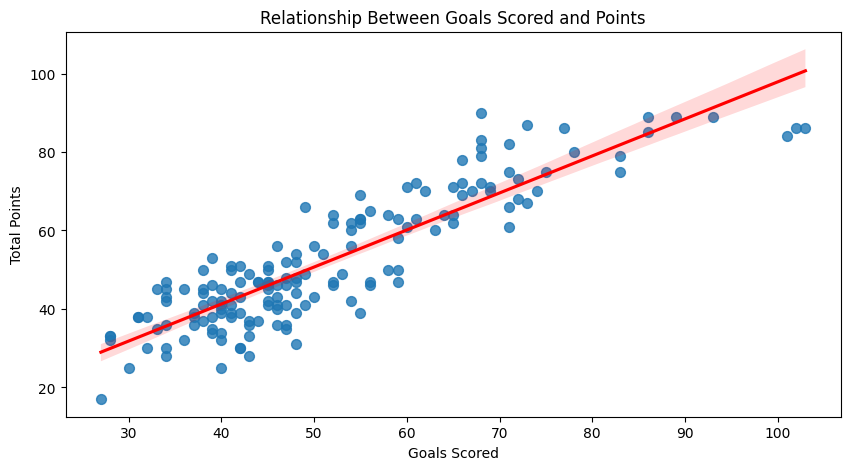

In [5]:
#lets see how goals effect points!
plt.figure(figsize=(10, 5))
sns.regplot(data=total_stats, x="goals_scored", y="total_points", scatter_kws={'s': 50}, line_kws={"color": "red"})
plt.xlabel("Goals Scored")
plt.ylabel("Total Points")
plt.title("Relationship Between Goals Scored and Points")
plt.show()


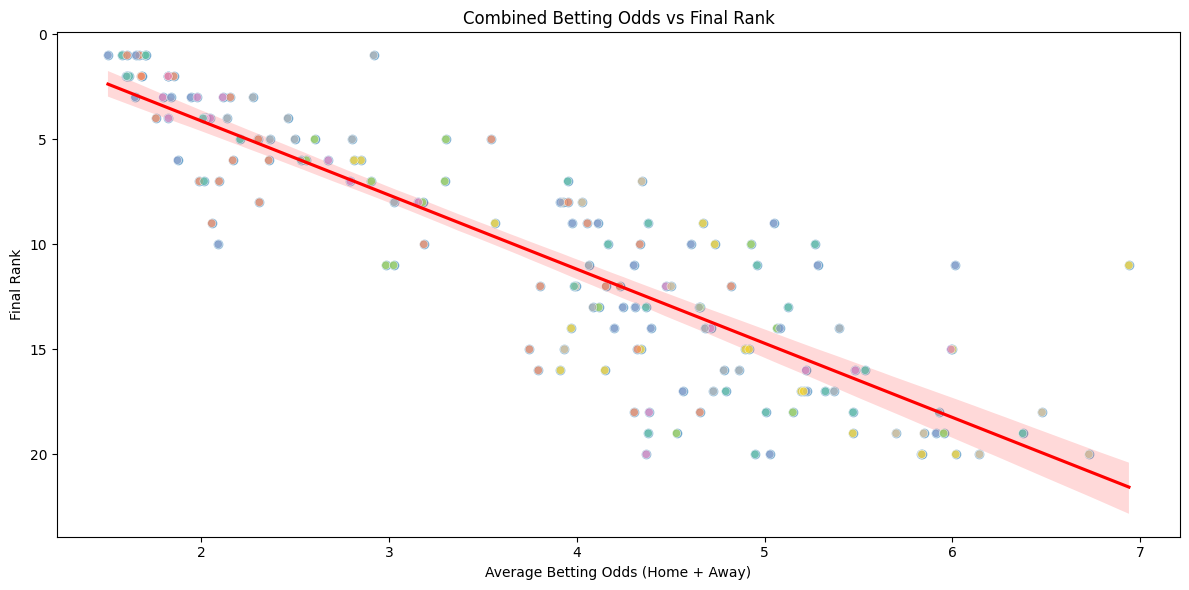

In [6]:
#let's create a combined plot with added trend line
plt.figure(figsize=(12, 6))

#make an average of home and away odds
total_stats['avg_betting_odds'] = (total_stats['avg_betting_odds_home'] + total_stats['avg_betting_odds_away']) / 2

sns.regplot(
    data=total_stats,
    x="avg_betting_odds",
    y="final_rank",
    scatter_kws={'alpha':0.5},
    line_kws={'color': 'red'},
)
sns.scatterplot(
    data=total_stats,
    x="avg_betting_odds",
    y="final_rank",
    hue="team_long_name",
    palette="Set2",
    alpha=0.7,
    legend=None
)
plt.xlabel("Average Betting Odds (Home + Away)")
plt.ylabel("Final Rank")
plt.title("Combined Betting Odds vs Final Rank")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

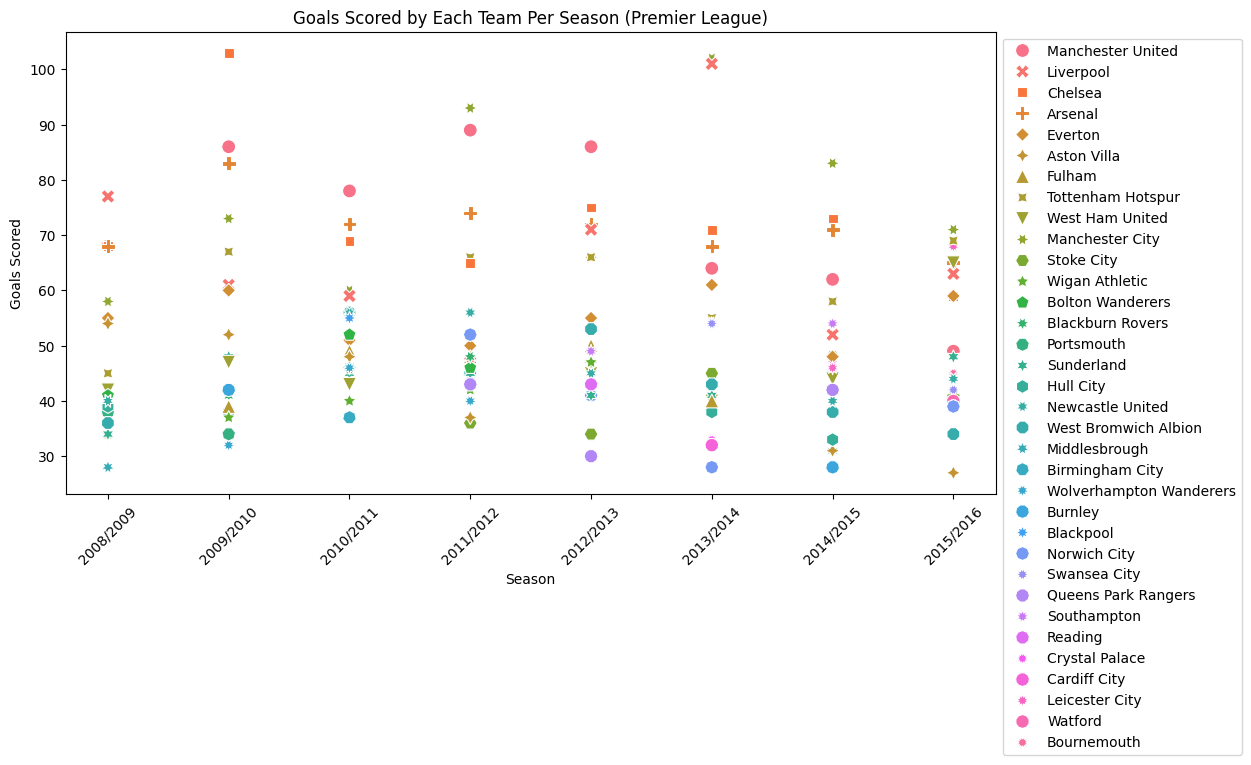

In [7]:
#lets start some simple visualizations of ourdata to get a feel for what we're dealing with
plt.figure(figsize=(12, 6))
sns.scatterplot(data=total_stats, x="season", y="goals_scored", hue="team_long_name", style="team_long_name", s=100)
plt.xticks(rotation=45)
plt.xlabel("Season")
plt.ylabel("Goals Scored")
plt.title("Goals Scored by Each Team Per Season (Premier League)")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


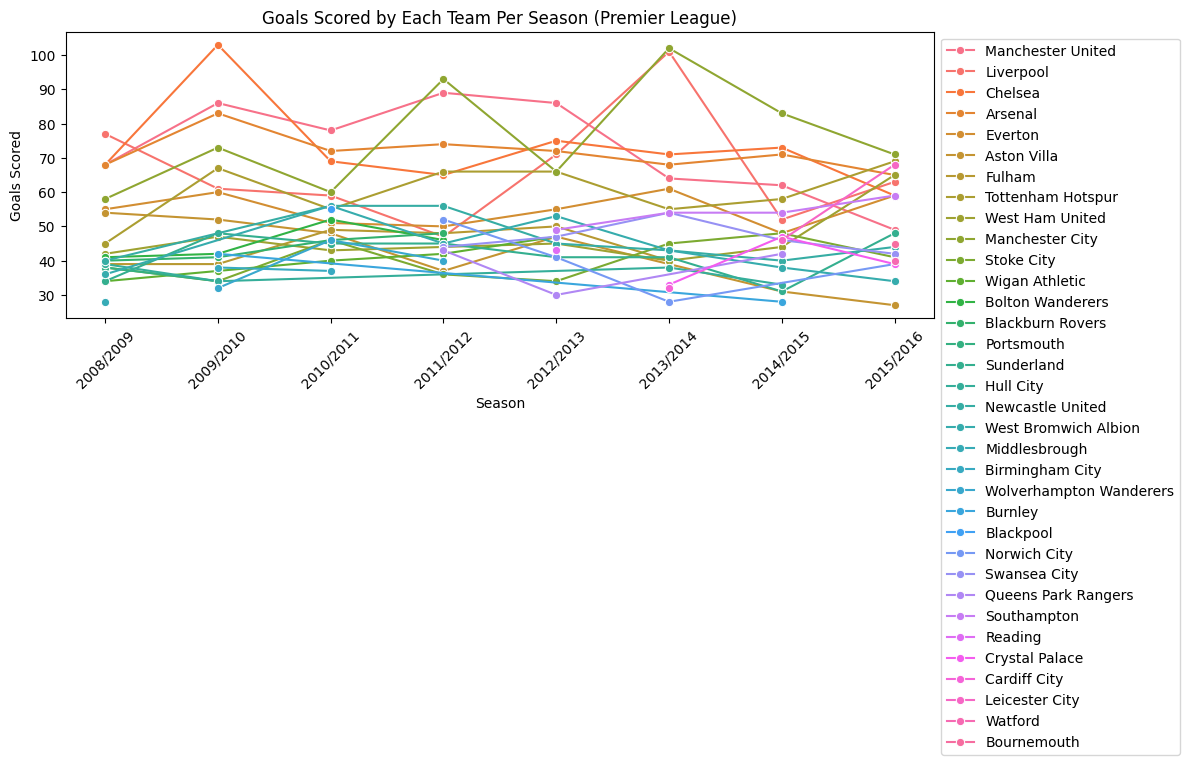

In [8]:
#similar to our previous plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=total_stats, x="season", y="goals_scored", hue="team_long_name", marker="o")
plt.xticks(rotation=45)
plt.xlabel("Season")
plt.ylabel("Goals Scored")
plt.title("Goals Scored by Each Team Per Season (Premier League)")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Move legend outside
plt.tight_layout()
plt.show()


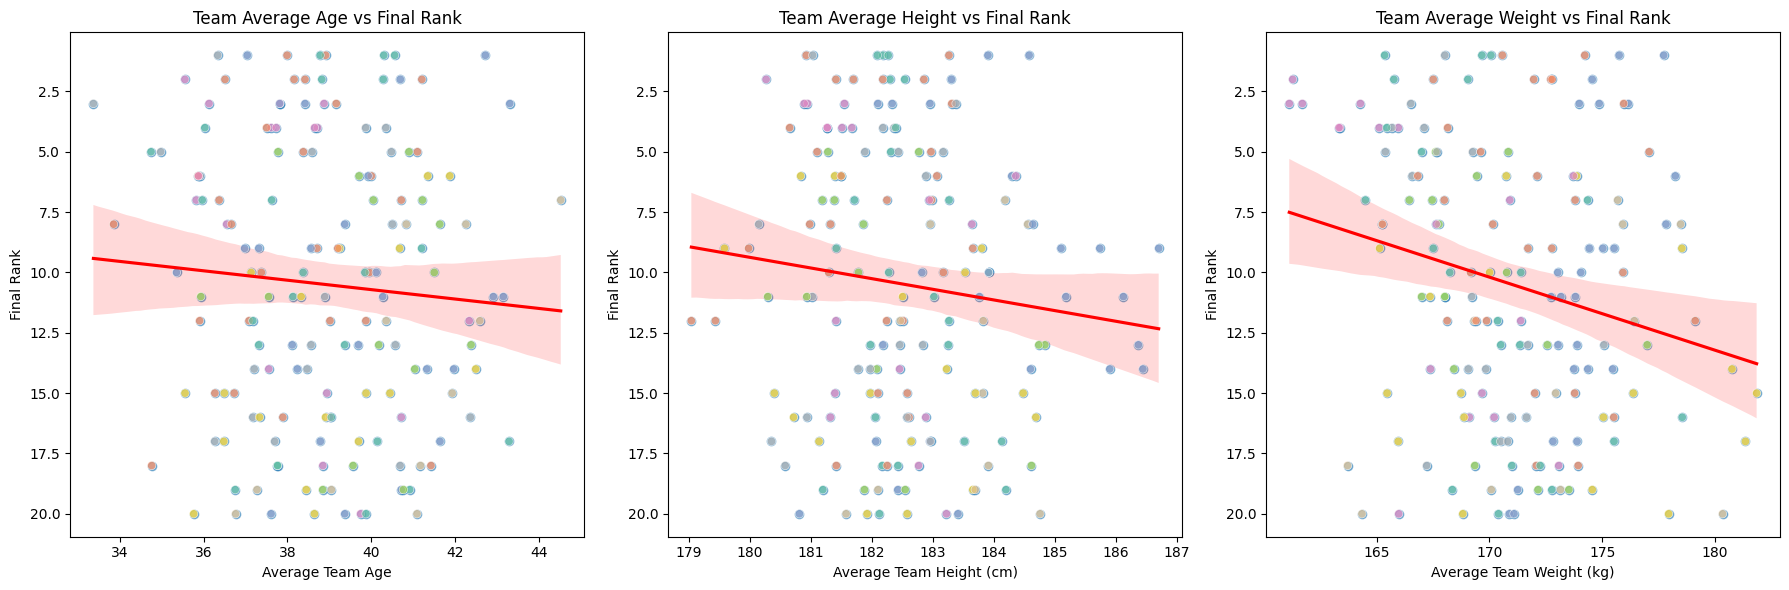

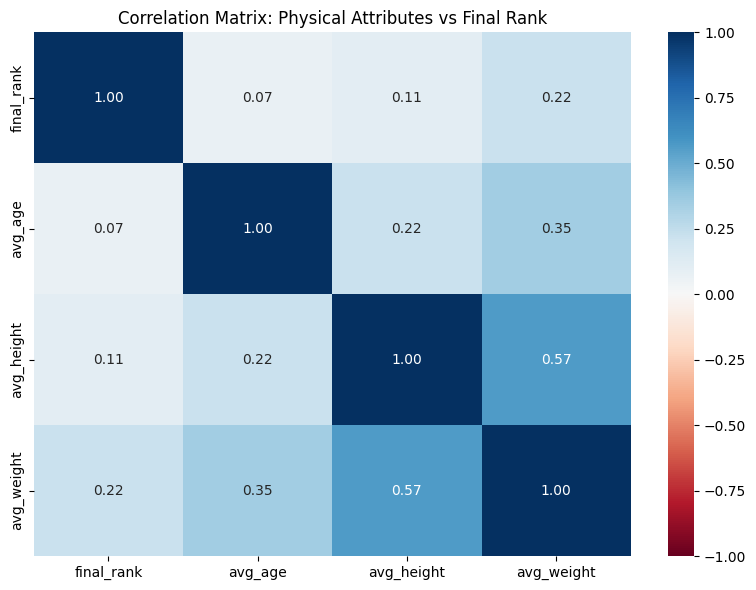

In [9]:
#lets look for correlation between our players attributes and winning
plt.figure(figsize=(18, 6))

#average age vs final rank
plt.subplot(1, 3, 1)
sns.regplot(
    data=total_stats,
    x="avg_age",
    y="final_rank",
    scatter_kws={'alpha':0.5},
    line_kws={'color': 'red'},
)
sns.scatterplot(
    data=total_stats,
    x="avg_age",
    y="final_rank",
    hue="team_long_name",
    palette="Set2",
    alpha=0.7,
    legend=None
)
plt.xlabel("Average Team Age")
plt.ylabel("Final Rank")
plt.title("Team Average Age vs Final Rank")
plt.gca().invert_yaxis()

#average height vs final rank
plt.subplot(1, 3, 2)
sns.regplot(
    data=total_stats,
    x="avg_height",
    y="final_rank",
    scatter_kws={'alpha':0.5},
    line_kws={'color': 'red'},
)
sns.scatterplot(
    data=total_stats,
    x="avg_height",
    y="final_rank",
    hue="team_long_name",
    palette="Set2",
    alpha=0.7,
    legend=None
)
plt.xlabel("Average Team Height (cm)")
plt.ylabel("Final Rank")
plt.title("Team Average Height vs Final Rank")
plt.gca().invert_yaxis()

#average weight vs final rank
plt.subplot(1, 3, 3)
sns.regplot(
    data=total_stats,
    x="avg_weight",
    y="final_rank",
    scatter_kws={'alpha':0.5},
    line_kws={'color': 'red'},
)
sns.scatterplot(
    data=total_stats,
    x="avg_weight",
    y="final_rank",
    hue="team_long_name",
    palette="Set2",
    alpha=0.7,
    legend=None
)
plt.xlabel("Average Team Weight (kg)")
plt.ylabel("Final Rank")
plt.title("Team Average Weight vs Final Rank")
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

#correlation matrix
correlation_vars = ['final_rank', 'avg_age', 'avg_height', 'avg_weight']
correlation_matrix = total_stats[correlation_vars].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix,
            annot=True,
            cmap='RdBu',
            center=0,
            vmin=-1,
            vmax=1,
            fmt='.2f')
plt.title('Correlation Matrix: Physical Attributes vs Final Rank')
plt.tight_layout()
plt.show()

In [10]:
#!! Creating and training a linear regression model
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#evaluate our model
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

#perform cross-validation
cv = 5  # number of folds
y_pred = cross_val_predict(model, X_scaled, y, cv=cv)

#calculate metrics
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f"Mean Absolute Error: {mae:.2f}")
print(f"R-squared Score: {r2:.2f}")

# Get cross-validated scores
cv_scores = cross_val_score(model, X_scaled, y, cv=cv, scoring='neg_mean_absolute_error')
cv_scores = -cv_scores  # Convert to positive values

print(f"\nCross-validation scores (MAE):")
print(f"Mean: {cv_scores.mean():.2f}")
print(f"Standard deviation: {cv_scores.std():.2f}")

#train the model
model.fit(X_scaled, y)

#create a function to predict for a specific team and season
def predict_team_finish(team_name, season):
    team_data = total_stats[(total_stats['team_long_name'] == team_name) &
                            (total_stats['season'] == season)]

    if team_data.empty:
        return "No data available for this team and season."

    features_to_use = ['goals_scored', 'goals_allowed', 'total_points',
                       'avg_betting_odds_home', 'avg_betting_odds_away',
                       'avg_age', 'avg_height', 'avg_weight', 'prev_season_rank']

    team_features = team_data[features_to_use].values
    scaled_features = scaler.transform(team_features)

    predicted_rank = model.predict(scaled_features)[0]
    actual_rank = team_data['final_rank'].values[0]

    return predicted_rank, actual_rank

#example! (change below)
team_name = "Leicester City"
season = "2015/2016"

predicted_rank, actual_rank = predict_team_finish(team_name, season)
print(f"\nPrediction for {team_name} in {season}:")
print(f"Predicted rank: {predicted_rank:.2f}")
print(f"Actual rank: {actual_rank}")
print(f"Prediction error: {abs(predicted_rank - actual_rank):.2f}")

#calculate predictions and errors for all teams in a specific season
season_to_predict = "2014/2015"
season_data = total_stats[total_stats['season'] == season_to_predict]

all_predictions = []
all_actuals = []

for _, row in season_data.iterrows():
    team = row['team_long_name']
    pred, actual = predict_team_finish(team, season_to_predict)
    all_predictions.append(pred)
    all_actuals.append(actual)

season_mae = mean_absolute_error(all_actuals, all_predictions)
season_r2 = r2_score(all_actuals, all_predictions)

print(f"\nPrediction metrics for {season_to_predict}:")
print(f"Mean Absolute Error: {season_mae:.2f}")
print(f"R-squared Score: {season_r2:.2f}")

#display feature importance
feature_importance = pd.DataFrame({'feature': features, 'importance': abs(model.coef_)})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)


Mean Absolute Error: 1.38
R-squared Score: 0.91

Cross-validation scores (MAE):
Mean: 1.38
Standard deviation: 0.16

Prediction for Leicester City in 2015/2016:
Predicted rank: 1.82
Actual rank: 1
Prediction error: 0.82

Prediction metrics for 2014/2015:
Mean Absolute Error: 0.93
R-squared Score: 0.95

Feature Importance:
                 feature  importance
2           total_points    4.924508
3  avg_betting_odds_home    1.051289
1          goals_allowed    0.623436
4  avg_betting_odds_away    0.620515
0           goals_scored    0.509096
7             avg_weight    0.182137
8       prev_season_rank    0.175499
5                avg_age    0.062967
6             avg_height    0.056145


Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 139.9194 - val_loss: 156.6152
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 128.4844 - val_loss: 150.9746
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 127.0808 - val_loss: 144.6588
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 111.1809 - val_loss: 137.9687
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 114.9740 - val_loss: 130.6884
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 105.7803 - val_loss: 122.8288
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 95.5004 - val_loss: 114.2797
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 89.6614 - val_loss: 104.9956
Epoch 9/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 78.9502 - val_loss: 94.9577
Epoch 10/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 73.3376 - val_loss: 83.9831
Epoch 11/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 68.4342 - val_loss: 72.6005
Epoch 12/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 

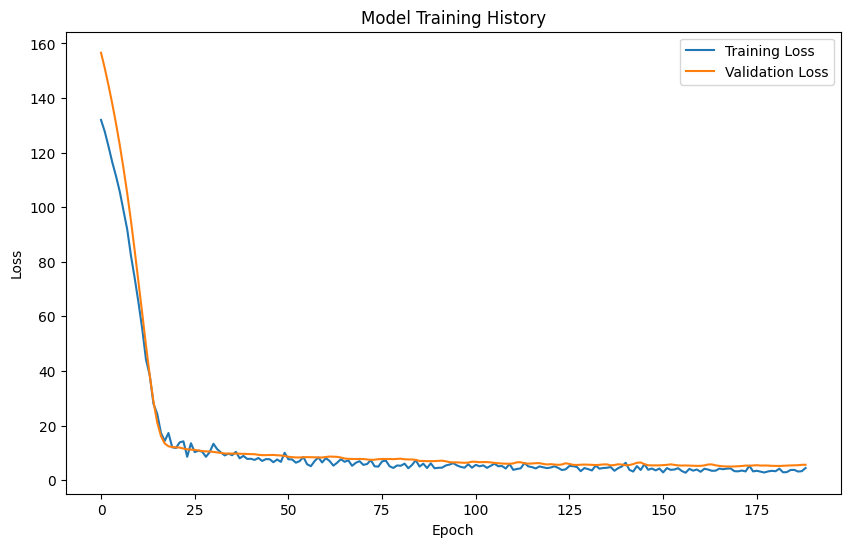

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step

Prediction for Manchester United in 2014/2015:
Predicted rank: 3.60
Actual rank: 4
Prediction error: 0.40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step

Prediction metrics for 2014/2015:
Mean Absolute Error: 0.96
R-squared Score: 0.96


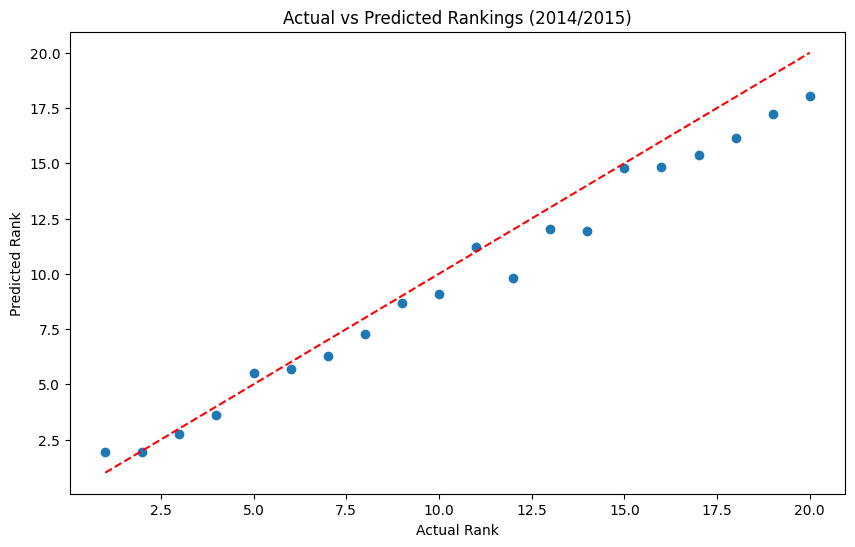

In [11]:
#! A neural network approach
X = total_stats[features]
y = total_stats['final_rank']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#defining the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(len(features),)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)  # Output layer (no activation for regression)
])

#compiling the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

#training the model
history = model.fit(
    X_train_scaled, y_train,
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

#evaluate loss
train_loss = model.evaluate(X_train_scaled, y_train, verbose=0)
test_loss = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Train MSE: {train_loss:.4f}")
print(f"Test MSE: {test_loss:.4f}")

#predictions
y_pred = model.predict(X_test_scaled).flatten()

#calculate MAE and R-squared
from sklearn.metrics import mean_absolute_error, r2_score
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R-squared Score: {r2:.2f}")

#visualize our training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#creating a function to predict for a specific team and season
def predict_team_finish(team_name, season):
    team_data = total_stats[(total_stats['team_long_name'] == team_name) &
                            (total_stats['season'] == season)]

    if team_data.empty:
        return "No data available for this team and season."

    team_features = team_data[features].values
    scaled_features = scaler.transform(team_features)

    predicted_rank = model.predict(scaled_features)[0][0]
    actual_rank = team_data['final_rank'].values[0]

    return predicted_rank, actual_rank

# Change the below to see!
team_name = "Manchester United"
season = "2014/2015"

predicted_rank, actual_rank = predict_team_finish(team_name, season)
print(f"\nPrediction for {team_name} in {season}:")
print(f"Predicted rank: {predicted_rank:.2f}")
print(f"Actual rank: {actual_rank}")
print(f"Prediction error: {abs(predicted_rank - actual_rank):.2f}")

#calc predictions and errors
season_to_predict = "2014/2015"
season_data = total_stats[total_stats['season'] == season_to_predict]

all_predictions = []
all_actuals = []

for _, row in season_data.iterrows():
    team = row['team_long_name']
    pred, actual = predict_team_finish(team, season_to_predict)
    all_predictions.append(pred)
    all_actuals.append(actual)

season_mae = mean_absolute_error(all_actuals, all_predictions)
season_r2 = r2_score(all_actuals, all_predictions)

print(f"\nPrediction metrics for {season_to_predict}:")
print(f"Mean Absolute Error: {season_mae:.2f}")
print(f"R-squared Score: {season_r2:.2f}")

#plot actual vs predicted rankings for a whole season (see season_to_predict)
plt.figure(figsize=(10, 6))
plt.scatter(all_actuals, all_predictions)
plt.plot([min(all_actuals), max(all_actuals)], [min(all_actuals), max(all_actuals)], 'r--')
plt.xlabel('Actual Rank')
plt.ylabel('Predicted Rank')
plt.title(f'Actual vs Predicted Rankings ({season_to_predict})')
plt.show()
